# Python package

We start with importing a few things we'll need. All required packages are installed during the setup process. 

In [30]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from openbabel.pybel import readfile

from delfta.calculator import DelftaCalculator
from delfta.utils import DATA_PATH

Next, we read a few example molecules. For more details on how to input your own molecules, see the documentation of the Pybel API [here](https://open-babel.readthedocs.io/en/latest/UseTheLibrary/Python_PybelAPI.html).

In [16]:
mol_files = glob.glob(os.path.join(DATA_PATH, "test_data", "*.sdf"))[:30] 
mols = [next(readfile("sdf", mol_file)) for mol_file in mol_files]

We'll initialize a calculator by stating which tasks we want to perform. Options are `all` (the default), `E_form`, `E_homo`, `E_lumo`, `E_gap`, `dipole`, and `charges`. You can also choose between `delta=True` (run a GNF2-xTB calculation and predict a delta correction to obtain an approximation of the DFT-value) or `delta=False` (predict the DFT-value directly from the molecular structure).

In [84]:
calc = DelftaCalculator(tasks=["charges"], delta=True)
predictions_delta = calc.predict(mols)

2021/06/18 03:27:58 PM | DelFTa | INFO: Now running network for model charges_delta...
2021/06/18 03:28:00 PM | DelFTa | INFO: Now running xTB...


ValueError: setting an array element with a sequence.

In [18]:
df = pd.DataFrame(predictions_delta)
df.insert(0, "structure", [os.path.basename(mol_file) for mol_file in mol_files])
df.rename(columns={"E_form": "E_form [Ha]", "E_homo": "E_homo [Ha]", "E_lumo": "E_lumo [Ha]", "E_gap": "E_gap [Ha]", "dipole": "dipole [D]", })

,structure,E_homo [Ha],E_lumo [Ha],E_gap [Ha],dipole [D],E_form [Ha]
0,CHEMBL4289810_conf_02.sdf,-0.301884,0.007817,0.309563,13.094598,-16.472244
1,CHEMBL3903980_conf_00.sdf,-0.308223,-0.016024,0.292466,9.587653,-11.918853
2,CHEMBL2435942_conf_01.sdf,-0.318627,0.013783,0.332709,5.714915,-12.358029
3,CHEMBL3912963_conf_01.sdf,-0.266440,0.037594,0.303944,2.964672,-13.600934
4,CHEMBL2348937_conf_01.sdf,-0.288944,-0.015563,0.273826,5.199066,-7.514140
5,CHEMBL3701649_conf_01.sdf,-0.264035,-0.004915,0.259089,2.653061,-16.458858
6,CHEMBL1362096_conf_01.sdf,-0.264291,0.032105,0.296510,4.257029,-11.608596
7,CHEMBL251530_conf_00.sdf,-0.284451,0.021219,0.305926,1.694772,-14.064029
8,CHEMBL344765_conf_01.sdf,-0.284691,0.019872,0.304547,3.298670,-12.108718
9,CHEMBL3891776_conf_00.sdf,-0.283724,0.036800,0.320663,3.732289,-13.258028


In [19]:
dft_keys = ["DFT:FORMATION_ENERGY", "DFT:HOMO_ENERGY", "DFT:LUMO_ENERGY", "DFT:HOMO_LUMO_GAP", "DFT:DIPOLE"]
dft_values = {}
for dft_key in dft_keys:
    if dft_key == "DFT:DIPOLE": 
        dft_values[dft_key] =  [float(mol.data[dft_key].split("|")[-1]) for mol in mols]
    else:
        dft_values[dft_key] = [float(mol.data[dft_key]) for mol in mols]



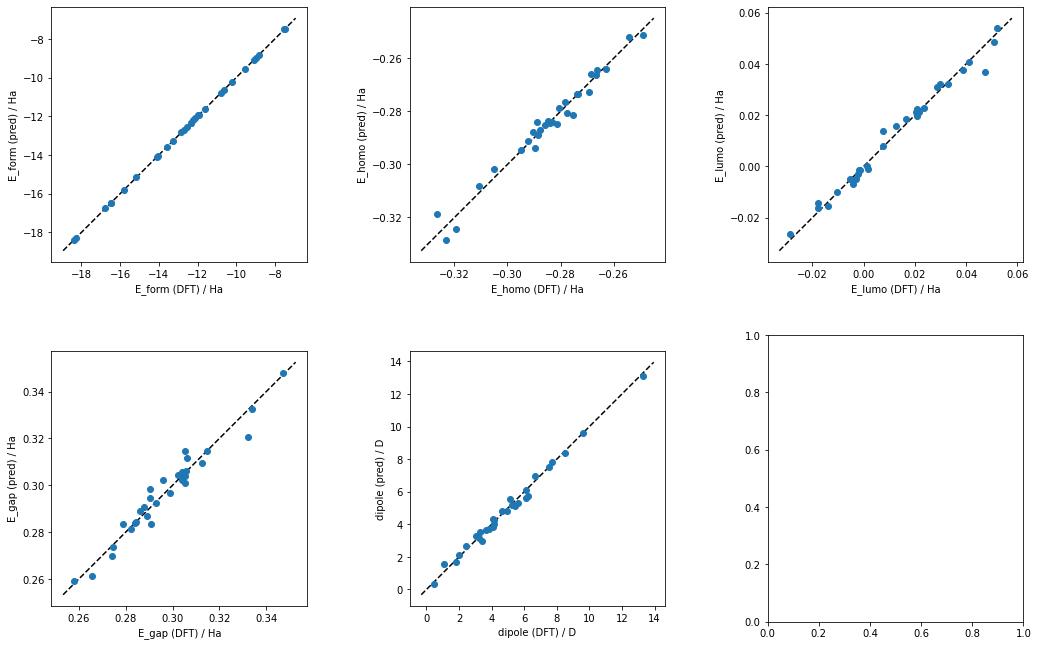

In [78]:
def make_plot(ax, dft_vals, pred_vals, label, unit): 
    ax.scatter(dft_vals, pred_vals)
    ax.set_xlabel(f"{label} (DFT) / {unit}")
    ax.set_ylabel(f"{label} (pred) / {unit}")
    min_val = [min(ax.get_ylim()[0], ax.get_xlim()[0])]
    max_val = [max(ax.get_ylim()[1], ax.get_xlim()[1])]
    ax.plot([min_val, max_val], [min_val, max_val], '--', color="black", zorder=-1)
    ax.set_aspect("equal", "box")

fig = plt.figure(figsize=(20, 12))
gs = GridSpec(nrows=2, ncols=3)
pred_keys = ["E_form", "E_homo", "E_lumo", "E_gap", "dipole"]
all_dft_vals = [dft_values[dft_key] for dft_key in dft_keys]
all_pred_vals = [predictions_delta[pred_key] for pred_key in pred_keys]
units = ["Ha", "Ha", "Ha", "Ha", "D"]
axes = [fig.add_subplot(gs[i,j]) for i in range(2) for j in range(3)]
for ax, dft_vals, pred_vals, label, unit in zip(axes, all_dft_vals, all_pred_vals, pred_keys, units): 
    make_plot(ax, dft_vals, pred_vals, label, unit)
plt.subplots_adjust(hspace=0.2, wspace=0.4, right=0.8, bottom=0.15)

